In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
from cipher import *
from scheme import *

from time import time
from PIL import Image

import torch
import torchvision.transforms as transforms

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
    device = "cpu"
else:
    print('CUDA is available!  Training on GPU ...')
    device = "cuda"

CUDA is available!  Training on GPU ...


# Original Pytorch model

Load ORG Pytorch model

In [4]:
from load_test_model import get_test_model
org_model = get_test_model()
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck']
org_model

ConvNeuralNet(
  (conv_layer1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_layer4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_layer5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

Load an image for test

In [5]:
img = np.array(Image.open("./bird6.png"))
to_tensor = transforms.ToTensor() # [n_channel, nh, nw]
img_tensor = to_tensor(img).unsqueeze(0) # [n_batch, n_channel, nh, nw]
n_batch, n_channel, nh, nw = img_tensor.shape

print(img_tensor.shape)

torch.Size([1, 3, 32, 32])


Load trained parameters

In [6]:
fn_param = "SimpleCNN_ReLU_minimax_v2.pt"

trained_param = torch.load(fn_param, map_location=torch.device(device))
trained_param = {k: v.cpu() for k, v in trained_param.items()} # to cpu()
org_model.load_state_dict(trained_param)
org_model.eval() ## If not eval(), running_mean and running_var of batch_norm changes

# To numpy
params_np = {k: v.numpy() for k, v in trained_param.items()}

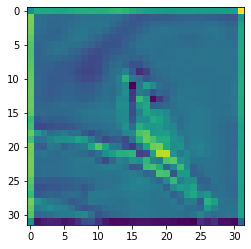

In [7]:
org_tt0 = org_model.conv_layer1(img_tensor)

x2 = org_tt0[0,0,...].detach().numpy()

plt.imshow(x2)

# FHE-friendly Conv

## SumSlots(ct; m, p)

sparse ctxt의 효율적인 sum reduce

In [114]:
from heconv import sumslots, VEC, multiplex
from heconv_tests import test_sumslots, test_VEC, test_multiplex
from math import floor, ceil, sqrt


In [24]:
test_sumslots(5, 2)

input:  [1 0 2 0 3 0 4 0 5 0]
sumslots test passed!
[15  0 15  0 15  0] == 15


### Vec
Numpy axis랑 논문 axis 순서가 다름.  


Numpy에서 (hi, wi, ci) 순서로 "보이게" array를 만들면 실제로는 ci, hi, wi 순서가 됨

In [102]:
test_VEC(3,4,5)

VEC Test passed
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59.  0.  0.  0.  0.]


### Multiplexed Packing

(4, 4, 3)
[[ 0.  1.  2.  3.]
 [ 4.  5.  6.  7.]
 [ 8.  9. 10. 11.]
 [12. 13. 14. 15.]]
[[  0.  10.  20.  30.]
 [ 40.  50.  60.  70.]
 [ 80.  90. 100. 110.]
 [120. 130. 140. 150.]]
[[   0.  100.  200.  300.]
 [ 400.  500.  600.  700.]
 [ 800.  900. 1000. 1100.]
 [1200. 1300. 1400. 1500.]]


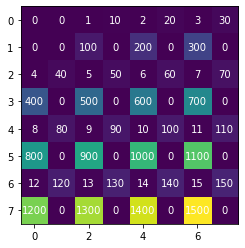

In [118]:
tt = test_multiplex()

## MultWgt(U;i1,i2,i)
transform a filter of size $F_h \times F_w \times C_i \times C_o$ to 1D 


Before, we define multiplexed shifted weight tensor

In [24]:
def get_Up(Uout, Uin, i1, i2, i, ki, fh, fw, hi, wi, ci):
    """Get an intermediate multiplexed representation of (fh,fw,ci,co)-shaped kernel.
        This will be VEC-ed and SIMD-multiplied with the input image
    """
    range_h = np.arange(hi)
    range_w = np.arange(wi)
    n3, n4, n5 = Uout.shape
    for i3 in range(n3):
        for i4 in range(n4):
            for i5 in range(n5):
                if  ki**2*i5+ki*(i3 % ki) + (i4 % ki) >= ci or \
                    not floor(i3 / ki) - int((fh -1)/2) in range_h or \
                    not floor(i4 / ki) - int((fw -1)/2) in range_w:
                    pass
                    #Uout[i3,i4,i5] = 0
                else:
                    #print("!!!")
                    #print(i1, i2, ki**2*i5+ki*(i3 % ki) + (i4 % ki), i)
                    Uout[i3,i4,i5] = Uin[i1,i2, ki**2*i5+ki*(i3 % ki) + (i4 % ki), i]

In [25]:
## Selecting 
def selecting_tensor(ko, ho, wo, i):
    """Gather multiplexed conv output into original form (Am I right??) 
    """
    S = np.zeros((ko*ho,ko*wo,to))
    n3, n4, n5 = S.shape
    for i3 in range(n3):
        for i4 in range(n4):
            for i5 in range(n5):
                if ko**2*i5 + ko*(i3 % ko) + (i4 % ko) == i:
                    S[i3,i4,i5] = 1

## Conv test script

In [119]:
# Multiplexed 

nslots = 16384

packed = VEC(multiplex(img),nslots)


numpy의 .reshape axis 순서가 내 생각과 다름...

reshape를 VEC()의 inverse로 새로 짜야할 듯 

In [121]:
packed.

(16384,)

In [ ]:

Uin = org_model.conv_layer1.weight.detach().numpy()
Uin = np.swapaxes(Uin,0,3)
Uin = np.swapaxes(Uin,1,2)
#Uin = np.swapaxes(Uin,0,1)

fh, fw, ci, co = Uin.shape
hi, wi, ci = img.shape
ki = ceil(sqrt(ci))
ko = ceil(sqrt(co))
ti = np.ceil(ci/ki**2).astype(int)

### no striding
ho = hi
wo = wi
###
to = np.ceil(co/ko**2).astype(int)

ctd = np.zeros(nslots)


cts=[]
for i1 in range(fh):
    cti1=[]
    for i2 in range(fw):
        cti1.append(np.roll(packed, -ki**2*wi*int(i1-(fh-1)/2) + ki*int(i2-(fw-1)/2))) # -?
    cts.append(cti1)

#len_multwgt = ki*

for i in range(co):
    ctb = np.zeros(nslots)
    for i1 in range(fh):
        for i2 in range(fw):
            Uout = np.zeros((ki*hi,ki*wi,ti))
            get_Up(Uout, Uin, i1, i2, i, ki, fh, fw, hi, wi, ci)
            multwgt = VEC(Uout, nslots)
            len_multwgt = len(multwgt)
            ctb[:len_multwgt] += cts[i1][i2][:len_multwgt] * multwgt            
    #print(ctb)
    ctc = sumslots(ctb, ki, 1)
    ctc = sumslots(ctc, ki, ki*wi) # ki or ko or another K?
    ctc = sumslots(ctc, ti, ki**2*hi*wi)

    S = selecting_tensor(ko, ho, wo, i)
    ctd += np.roll(ctc, (floor(i/ko**2)*ko**2*ho*wo + floor((i % ko**2)/ko)*ko*wo + (i % ko))) * VEC(S, nslots)

In [201]:
Uout.shape

(64, 64, 1)

## 결과: index bug? 

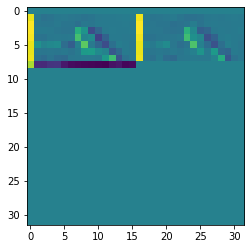

In [200]:
out2d = ctd.reshape(128,128)

plt.imshow(out2d[0::4,0::4])